# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import Dataset
from typing import List, Tuple
import torchmetrics

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [6]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [7]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)  #  seed для CPU
    torch.cuda.manual_seed(seed)  # seed для GPU
    np.random.seed(seed)  # seed для NumPy
    random.seed(seed)  # seed для Python

In [8]:
set_random_seed(42)  # Задаем seed для воспроизводимости
# Выполняем стандартизацию данных на обучающей и тестовой выборках с помощью объекта `StandardScaler`
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Тренировочная выборка
X_test_scaled = scaler.transform(X_test)  # Тестовая выборка

model_ridge = Ridge(random_state=42)  # Создаем модель Ridge
model_ridge.fit(X=X_train_scaled, y=y_train)  # Обучаем с помощью модели `Ridge` на стандартизированных данных

Ridge(random_state=42)

In [9]:
predictions_ridge = model_ridge.predict(X_test_scaled)  # Делаем прогноз на тестовой выборке
rmse_for_model = mean_squared_error(y_true=y_test,
                                    y_pred=predictions_ridge,
                                    squared=False)  # Рассчитываем RMSE

print(f"RMSE для модели Ridge: {rmse_for_model:.2f}")

RMSE для модели Ridge: 9.51


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
# Рассчет RMSE для лучшего константного прогноза (среднее значение y_train)
best_rmse_metric = mean_squared_error(y_true=y_test,
                                      y_pred=np.full_like(y_test, np.mean(y_train)),
                                      squared=False)

# Выводим на экран RMSE для лучшего константного прогноза
print(f"RMSE для лучшего константного прогноза: {best_rmse_metric:.2f}")

RMSE для лучшего константного прогноза: 10.86


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
# Определяем класс модели линейной регрессии
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim: int):
        """
        Инициализация модели линейной регрессии.

        :param input_dim: int, количество признаков во входных данных.
        """
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Прямой проход модели.

        :param x: torch.Tensor, входные данные.
        :return: torch.Tensor, предсказания модели.
        """
        return self.linear(x)

In [27]:
def mse_loss(y_pred_: torch.Tensor,
             y_true_: torch.Tensor) -> torch.Tensor:
    """
    Расчет среднеквадратичной ошибки.

    :param y_pred_: torch.Tensor, предсказанные значения.
    :param y_true_: torch.Tensor, истинные значения.
    :return: torch.Tensor, значение ошибки.
    """
    return torch.mean((y_pred_ - y_true_) ** 2)

In [28]:
learning_rate = 0.01  # Скорость обучения
epochs = 10  # Количество эпох обучения

model_lr = LinearRegressionModel(X_train_scaled.shape[1]).float()  # Создание модели линейной регрессии

# Конвертируем данные в тензоры Torch
X_train_tensor_0 = torch.tensor(X_train_scaled, dtype=torch.float32)  # Входные данные обучающей выборки
y_train_tensor_0 = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Выходные данные обучающей выборки
X_test_tensor_0 = torch.tensor(X_test_scaled, dtype=torch.float32)  # Входные данные тестовой выборки
y_test_tensor_0 = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Выходные данные тестовой выборки

In [29]:
# Создаем списки для отслеживания функции потерь и метрик на обучающей и тестовой выборках
train_losses_0, test_losses_0, test_metrics_0 = [], [], []

# Цикл обучения
for epoch in range(epochs):
    y_pred = model_lr(X_train_tensor_0)  # Прямой проход: вычисляем предсказанные значения, применяя модель к данным
    # Расчёт и вывод потери
    loss = mse_loss(y_pred_=y_pred, y_true_=y_train_tensor_0)
    train_losses_0.append(loss.item())
    
    # Обнуление градиентов. Выполнение обратного прохода, обновление весов модели
    model_lr.zero_grad()
    loss.backward()
    
    # Обновление параметров модели
    for param in model_lr.parameters():
        param.data -= learning_rate * param.grad
        
    # Оценка на тестовых данных
    with torch.no_grad():
        y_test_pred = model_lr(X_test_tensor_0)
        test_loss = mse_loss(y_test_pred, y_test_tensor_0)
        test_losses_0.append(test_loss.item())
        test_metric = torch.sqrt(test_loss).item()
        test_metrics_0.append(test_metric)

    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Train Loss: {loss.item():.4f}, '
          f'Test Loss: {test_loss.item():.4f}, '
          f'Test RMSE: {test_metric:.4f}')
    print('=====================================================================================')

Epoch 1/10, Train Loss: 3993405.5000, Test Loss: 3835647.0000, Test RMSE: 1958.4808
Epoch 2/10, Train Loss: 3835269.2500, Test Loss: 3683756.0000, Test RMSE: 1919.3113
Epoch 3/10, Train Loss: 3683396.0000, Test Loss: 3537880.0000, Test RMSE: 1880.9253
Epoch 4/10, Train Loss: 3537537.2500, Test Loss: 3397781.5000, Test RMSE: 1843.3073
Epoch 5/10, Train Loss: 3397453.7500, Test Loss: 3263230.7500, Test RMSE: 1806.4414
Epoch 6/10, Train Loss: 3262918.2500, Test Loss: 3134008.7500, Test RMSE: 1770.3132
Epoch 7/10, Train Loss: 3133710.0000, Test Loss: 3009904.5000, Test RMSE: 1734.9076
Epoch 8/10, Train Loss: 3009618.7500, Test Loss: 2890715.2500, Test RMSE: 1700.2103
Epoch 9/10, Train Loss: 2890441.5000, Test Loss: 2776245.7500, Test RMSE: 1666.2070
Epoch 10/10, Train Loss: 2775984.0000, Test Loss: 2666310.5000, Test RMSE: 1632.8842


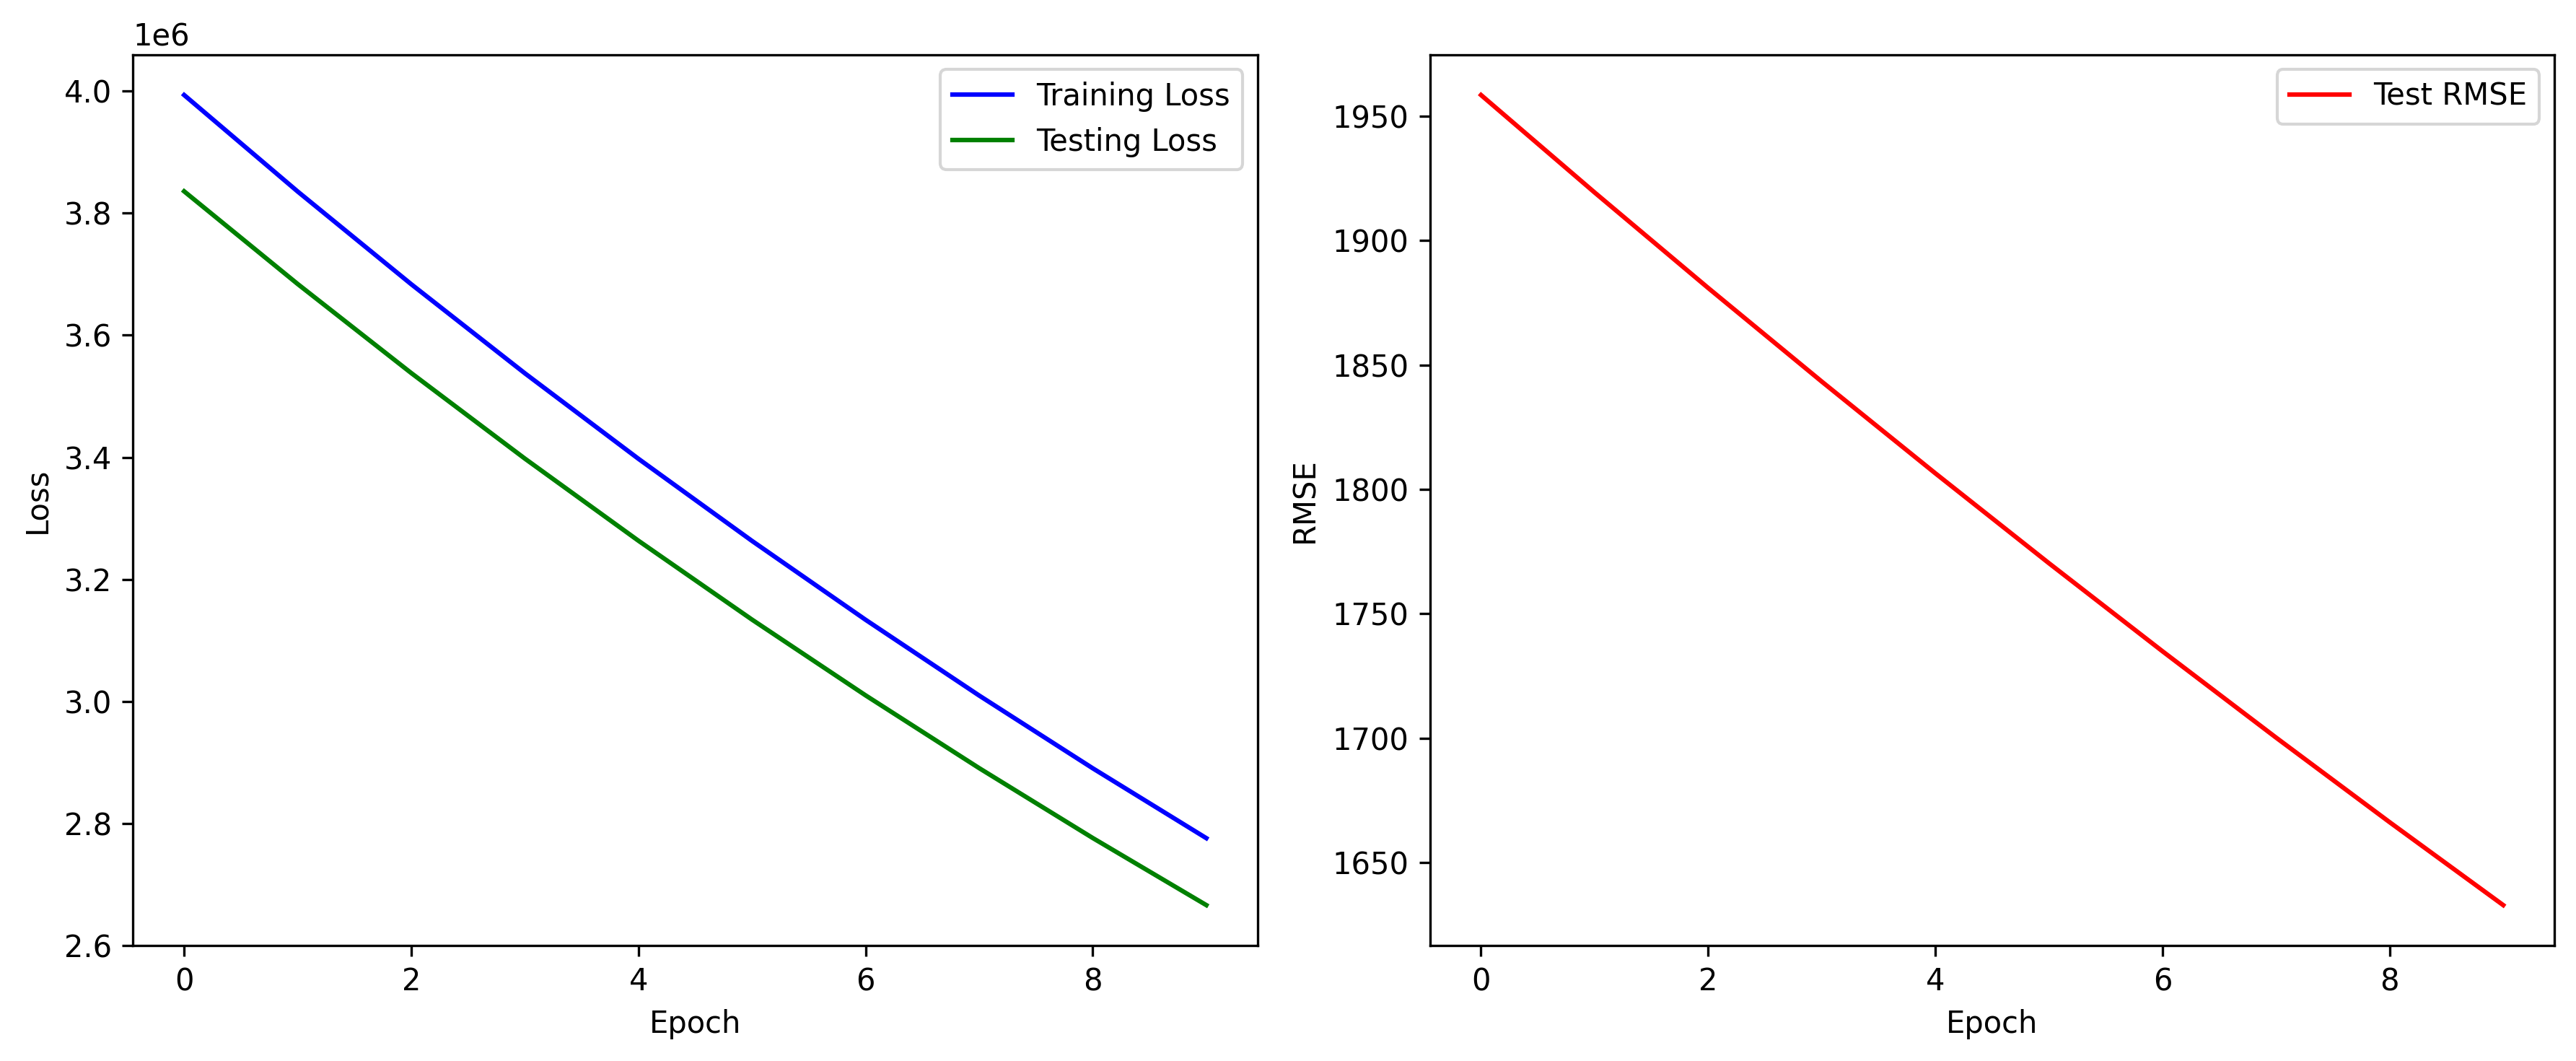

In [30]:
# Визуализация результатов обучения
plt.figure(figsize=(12, 5), dpi=300)

# График функции потерь на обучающей и тестовой выборке
plt.subplot(1, 2, 1)
plt.plot(train_losses_0, label='Training Loss', color='blue')
plt.plot(test_losses_0, label='Testing Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График RMSE на тестовой выборке
plt.subplot(1, 2, 2)
plt.plot(test_metrics_0, label='Test RMSE', color='red')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [13]:
set_random_seed(42)  # seed для воспроизводимости

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)  # Стандартизация тренировочной выборки
X_test = scaler.transform(X_test)  # Стандартизация тестовой выборки

y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()  # Стандартизация тренировочных меток
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()  # Стандартизация тестовых меток

In [14]:
class MyDataset(Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor):
        """
        Инициализирует пользовательский датасет.
        :param x: torch.Tensor, входные данные
        :param y: torch.Tensor, выходные данные (метки)
        """
        self.x = x
        self.y = y

    def __len__(self) -> int:
        """
        Возвращает длину датасета.
        :return: int, длина датасета
        """
        return len(self.x)

    def __getitem__(self, index: int) -> tuple:
        """
        Возвращает элемент датасета по индексу.
        :param idx: int, индекс элемента
        :return: tuple, содержащий входные данные и соответствующие им выходные данные
        """
        return self.x[index, :], self.y[index]

In [16]:
# Преобразование данных в формат torch.FloatTensor для обучения на PyTorch
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [17]:
train_set = MyDataset(X_train, y_train)  # Создание объекта датасета для тренировочных данных
# Создание загрузчика данных для эффективного обучения с разделением на батчи и перемешиванием
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)

test_set = MyDataset(X_test, y_test)  # Создание объекта датасета для тестовых данных
# Создание загрузчика данных для тестирования без перемешивания
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

In [18]:
class Net(nn.Module):
    def __init__(self, input_size: int):
        """
        Инициализация нейросети.

        :param input_size: int, количество признаков во входных данных
        """
        super(Net, self).__init__()
        # Определение слоев нейросети
        self.fc1 = nn.Linear(input_size, 256)  # Полносвязный слой, имеет 256 выходных нейронов
        self.fc2 = nn.Linear(256, 128)  # Полносвязный слой, имеет 128 выходных нейронов
        self.fc3 = nn.Linear(128, 64)  # Полносвязный слой, имеет 64 выходных нейрона
        self.fc4 = nn.Linear(64, 1)  # Полносвязный слой, имеет 1 выходной нейрон (регрессионный случай)
        self.dropout = nn.Dropout(0.5)  # Dropout слой для регуляризации, имеет вероятность отключения 50%

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Прямой проход по сети.

        :param x: torch.Tensor, входные данные
        :return: torch.Tensor, выходные данные
        """
        x = torch.relu(self.fc1(x))  # Применение ReLU активации к первому скрытому слою
        x = self.dropout(x)  # Применение Dropout для регуляризации
        x = torch.relu(self.fc2(x))  # Применение ReLU активации ко второму скрытому слою
        x = self.dropout(x)  # Применение Dropout для регуляризации
        x = torch.relu(self.fc3(x))  # Применение ReLU активации к третьему скрытому слою
        x = self.dropout(x)  # Применение Dropout для регуляризации
        x = self.fc4(x)  # Выходной слой (регрессионный случай)
        return x

In [19]:
def train(model_: nn.Module,
          optimizer_: torch.optim.Optimizer,
          criterion_: nn.Module,
          train_loader_: torch.utils.data.DataLoader,
          test_loader_: torch.utils.data.DataLoader,
          scaler_: StandardScaler = scaler,
          epochs_: int = 10) -> Tuple[List[float], List[float], List[float]]:
    """
    Обучает модель и оценивает ее производительность на тестовых данных.

    :param model_: Модель для обучения
    :param optimizer_: Оптимизатор для обновления весов модели
    :param criterion_: Функция потерь для оптимизации
    :param train_loader_: DataLoader для обучающих данных
    :param test_loader_: DataLoader для тестовых данных
    :param scaler_: Объект для стандартизации данных (по умолчанию используется глобальный scaler)
    :param epochs_: Количество эпох обучения
    :return: Список RMSE на тренировочной выборке, список RMSE на тестовой выборке, список общего RMSE на тестовой выборке
    """
    model_.to(device)  # Перевод модели на GPU, если доступен

    RMSE_train_list = []  # Список для хранения RMSE на тренировочной выборке
    RMSE_test_list = []  # Список для хранения RMSE на тестовой выборке
    RMSE_total_list = []  # Список для хранения общего RMSE на тестовой выборке

    for epoch in range(epochs_):

        RMSE_train = []  # Список для хранения RMSE на тренировочной выборке в текущей эпохе
        model_.train()  # Перевод модели в режим обучения
        for x_train, y_train in tqdm(train_loader_):
            x_train, y_train = x_train.to(device), y_train.to(device)  # Перевод данных на GPU
            y_pred = model_(x_train).flatten()  # Прямой проход и получение предсказаний
            loss_train_batch = torch.sqrt(criterion_(y_pred, y_train))  # Вычисление потери и RMSE на текущем батче
            loss_train_batch.backward()  # Обратное распространение градиентов
            optimizer_.step()  # Обновление весов модели
            optimizer_.zero_grad()  # Сброс градиентов
            rmse_train_batch = mean_squared_error(scaler_.inverse_transform(y_train.cpu().numpy().reshape(-1, 1)),
                                                  scaler_.inverse_transform(
                                                      y_pred.cpu().detach().numpy().reshape(-1, 1)),
                                                  squared=False)
            RMSE_train.append(rmse_train_batch)  # Добавление RMSE текущего батча в список

        test_values, predicts, RMSE_test = [], [], []  # Пустые списки для хранения данных на тестовой выборке
        model_.eval()  # Перевод модели в режим оценки (без вычисления градиентов)
        with torch.no_grad():  # Отключение вычисления градиентов для тестовых данных
            for x_test, y_test in tqdm(test_loader_):
                x_test, y_test = x_test.to(device), y_test.to(device)  # Перевод данных на GPU
                y_pred = model_(x_test).flatten()  # Прямой проход и получение предсказаний
                predicts.append(y_pred)  # Добавление предсказания текущего батча
                test_values.append(y_test)  # Добавление истинных значений текущего батча
                rmse_test_batch = mean_squared_error(scaler_.inverse_transform(y_test.cpu().numpy().reshape(-1, 1)),
                                                     scaler_.inverse_transform(y_pred.cpu().numpy().reshape(-1, 1)),
                                                     squared=False)
                RMSE_test.append(rmse_test_batch)  # Добавление RMSE текущего батча в список

        predicts = torch.cat(predicts).cpu().numpy()  # Конкатенация предсказаний
        test_values = torch.cat(test_values).cpu().numpy()  # Конкатенация истинных значений

        RMSE_total = mean_squared_error(scaler_.inverse_transform(test_values.reshape(-1, 1)),
                                        scaler_.inverse_transform(predicts.reshape(-1, 1)),
                                        squared=False)  # Вычисление общего RMSE на тестовой выборке

        RMSE_train_list.append(np.mean(RMSE_train))  # Среднее RMSE на тренировочной выборке в текущей эпохе
        RMSE_test_list.append(np.mean(RMSE_test))  # Среднее RMSE на тестовой выборке в текущей эпохе
        RMSE_total_list.append(RMSE_total)  # Общий RMSE на тестовой выборке

        print(f'Epoch: {epoch}')
        print(f'RMSE train: {RMSE_train_list[-1]:.5f}')
        print(f'RMSE test: {RMSE_test_list[-1]:.5f}')
        print(f'RMSE total: {RMSE_total:.5f}')

    return RMSE_train_list, RMSE_test_list, RMSE_total_list


def test(model_: nn.Module,
         criterion_: nn.Module,
         test_loader_: DataLoader) -> torch.Tensor:
    """
    Проводит оценку модели на тестовом наборе данных.

    :param model_: nn.Module, модель, которую нужно оценить на тестовом наборе данных.
    :param criterion_: nn.Module, loss-функция из библиотеки torch.nn.
    :param test_loader_: DataLoader, загрузчик данных с тестовым набором данных.

    :return: torch.Tensor, содержащий предсказания для тестовых объектов.
    """
    model_.eval()  # Перевод модели в режим оценки
    predicts = []  # Список для хранения предсказаний модели
    total_loss = 0.0  # Переменная для накопления общей потери

    with torch.no_grad():  # Отключение вычисления градиентов во время вывода
        for inputs, labels in test_loader_:
            # Получение предсказания модели для текущей партии данных, удаление дополнительных измерений
            outputs = model_(inputs).squeeze()
            loss = criterion_(outputs, labels)  # Вычисление потери
            total_loss += loss.item()  # Накопление потери
            predicts.append(outputs)  # Сохранение предсказания

    avg_loss = total_loss / len(test_loader_)  # Вычисление средней потери на тестовом наборе данных
    predicts = torch.cat(predicts)  # Объединение всех предсказаний в один тензор

    print(f'Average Test Loss: {avg_loss:.4f}')  # Вывод средней потери на тестовом наборе данных

    return predicts

In [20]:
set_random_seed(42)
model_1 = Net(X_train.shape[1]).to(device)  # Инициализация модели
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.01)  # Инициализация оптимизатора
criterion_1 = nn.MSELoss()  # Инициализация функции потерь

In [21]:
assert test(model_=model_1,
            criterion_=criterion_1,
            test_loader_=test_loader).shape[0] == y_test.shape[0]

Average Test Loss: 0.9949


In [22]:
RMSE_train_list_1, RMSE_test_list_1, RMSE_total_list_1 = train(model_=model_1,
                                                               optimizer_=optimizer_1,
                                                               criterion_=criterion_1,
                                                               train_loader_=train_loader,
                                                               test_loader_=test_loader,
                                                               epochs_=5)

100%|██████████| 517/517 [00:01<00:00, 389.69it/s]


Epoch: 0
RMSE train: 10.11495
RMSE test: 8.97258
RMSE total: 9.86024


100%|██████████| 517/517 [00:01<00:00, 406.43it/s]


Epoch: 1
RMSE train: 10.17022
RMSE test: 9.39437
RMSE total: 10.36840


100%|██████████| 517/517 [00:00<00:00, 532.24it/s]


Epoch: 2
RMSE train: 10.25549
RMSE test: 9.32119
RMSE total: 10.35347


100%|██████████| 517/517 [00:01<00:00, 264.71it/s]


Epoch: 3
RMSE train: 10.30372
RMSE test: 9.34720
RMSE total: 10.36153


100%|██████████| 517/517 [00:00<00:00, 613.33it/s]

Epoch: 4
RMSE train: 10.37008
RMSE test: 9.23252
RMSE total: 10.15683


*Видим, что показатели довольно неплохие, использую $lr=0.01$ и оптимизатор **Adam*** 

In [23]:
set_random_seed(42)
model_2 = Net(X_train_scaled.shape[1]).to(device)
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=0.05)
criterion_2 = nn.MSELoss()

In [24]:
assert test(model_=model_2,
            criterion_=criterion_2,
            test_loader_=test_loader).shape[0] == y_test.shape[0]

Average Test Loss: 0.9949


In [25]:
set_random_seed(42)
RMSE_train_list_2, RMSE_test_list_2, RMSE_total_list_2 = train(model_=model_2,
                                                               optimizer_=optimizer_2,
                                                               criterion_=criterion_2,
                                                               train_loader_=train_loader,
                                                               test_loader_=test_loader,
                                                               epochs_=10)

100%|██████████| 517/517 [00:00<00:00, 553.60it/s]


Epoch: 0
RMSE train: 9.53822
RMSE test: 8.29278
RMSE total: 9.02080


100%|██████████| 517/517 [00:00<00:00, 576.50it/s]


Epoch: 1
RMSE train: 9.09230
RMSE test: 8.12784
RMSE total: 8.97549


100%|██████████| 517/517 [00:00<00:00, 524.77it/s]


Epoch: 2
RMSE train: 8.98789
RMSE test: 8.09180
RMSE total: 8.91019


100%|██████████| 517/517 [00:00<00:00, 533.73it/s]


Epoch: 3
RMSE train: 8.92907
RMSE test: 8.10204
RMSE total: 8.90824


100%|██████████| 517/517 [00:00<00:00, 571.79it/s]


Epoch: 4
RMSE train: 8.88186
RMSE test: 8.10640
RMSE total: 8.84857


100%|██████████| 517/517 [00:01<00:00, 514.38it/s]


Epoch: 5
RMSE train: 8.85413
RMSE test: 8.11619
RMSE total: 8.83982


100%|██████████| 517/517 [00:00<00:00, 554.70it/s]


Epoch: 6
RMSE train: 8.82596
RMSE test: 8.06397
RMSE total: 8.80442


100%|██████████| 517/517 [00:00<00:00, 555.68it/s]


Epoch: 7
RMSE train: 8.80587
RMSE test: 8.07446
RMSE total: 8.80533


100%|██████████| 517/517 [00:00<00:00, 534.56it/s]


Epoch: 8
RMSE train: 8.78856
RMSE test: 8.04780
RMSE total: 8.79135


100%|██████████| 517/517 [00:00<00:00, 570.68it/s]

Epoch: 9
RMSE train: 8.77367
RMSE test: 8.00317
RMSE total: 8.77918


Попробовал увеличить $lr=0.05$, также изменил оптимизиатор на **SGD**, RMSE_total уменьшилось, это хорошо, но поэкспериментируем ещё. (-_-)

In [26]:
set_random_seed(42)
model_3 = Net(X_train_scaled.shape[1]).to(device)
optimizer_3 = torch.optim.SGD(model_3.parameters(), lr=0.05, weight_decay=0.001)
criterion_3 = nn.MSELoss()

In [27]:
assert test(model_=model_3,
            criterion_=criterion_3,
            test_loader_=test_loader).shape[0] == y_test.shape[0]

Average Test Loss: 0.9949


In [28]:
set_random_seed(42)
RMSE_train_list_3, RMSE_test_list_3, RMSE_total_list_3 = train(model_=model_3,
                                                               optimizer_=optimizer_3,
                                                               criterion_=criterion_3,
                                                               train_loader_=train_loader,
                                                               test_loader_=test_loader,
                                                               epochs_=10)

100%|██████████| 517/517 [00:00<00:00, 571.20it/s]


Epoch: 0
RMSE train: 9.50935
RMSE test: 8.25212
RMSE total: 8.99438


100%|██████████| 517/517 [00:01<00:00, 489.14it/s]


Epoch: 1
RMSE train: 9.04665
RMSE test: 8.12312
RMSE total: 8.97545


100%|██████████| 517/517 [00:01<00:00, 470.01it/s]


Epoch: 2
RMSE train: 8.93428
RMSE test: 8.05408
RMSE total: 8.90560


100%|██████████| 517/517 [00:00<00:00, 563.40it/s]


Epoch: 3
RMSE train: 8.88677
RMSE test: 8.05504
RMSE total: 8.87778


100%|██████████| 517/517 [00:00<00:00, 564.15it/s]


Epoch: 4
RMSE train: 8.85384
RMSE test: 8.10501
RMSE total: 8.83618


100%|██████████| 517/517 [00:01<00:00, 498.78it/s]


Epoch: 5
RMSE train: 8.84525
RMSE test: 8.07182
RMSE total: 8.82065


100%|██████████| 517/517 [00:00<00:00, 569.56it/s]


Epoch: 6
RMSE train: 8.82673
RMSE test: 8.05032
RMSE total: 8.81934


100%|██████████| 517/517 [00:00<00:00, 587.91it/s]


Epoch: 7
RMSE train: 8.81800
RMSE test: 8.06848
RMSE total: 8.85698


100%|██████████| 517/517 [00:00<00:00, 567.08it/s]


Epoch: 8
RMSE train: 8.81313
RMSE test: 8.05894
RMSE total: 8.80435


100%|██████████| 517/517 [00:01<00:00, 492.81it/s]


Epoch: 9
RMSE train: 8.81410
RMSE test: 8.01403
RMSE total: 8.85730


Результат близок к цели, в этом раз я решил добавить коэффициент регуляризации $weight\_decay=0.001$, но он не очень помог (я ещё другие пробовал, но не стал вставлять, очень много и без этого). Попробую изменить $batch\_size$.

In [29]:
train_set = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)

test_set = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256)

In [30]:
set_random_seed(42)
model_4 = Net(X_train_scaled.shape[1]).to(device)
optimizer_4 = torch.optim.SGD(model_4.parameters(), lr=0.05)
criterion_4 = nn.MSELoss()

In [31]:
assert test(model_=model_4,
            criterion_=criterion_4,
            test_loader_=test_loader).shape[0] == y_test.shape[0]

Average Test Loss: 1.0058


In [32]:
set_random_seed(42)
RMSE_train_list_4, RMSE_test_list_4, RMSE_total_list_4 = train(model_=model_4,
                                                               optimizer_=optimizer_4,
                                                               criterion_=criterion_4,
                                                               train_loader_=train_loader,
                                                               test_loader_=test_loader,
                                                               epochs_=10)

100%|██████████| 202/202 [00:00<00:00, 255.59it/s]


Epoch: 0
RMSE train: 9.98243
RMSE test: 8.81091
RMSE total: 9.19761


100%|██████████| 202/202 [00:00<00:00, 297.96it/s]


Epoch: 1
RMSE train: 9.34052
RMSE test: 8.63796
RMSE total: 9.03735


100%|██████████| 202/202 [00:00<00:00, 277.41it/s]


Epoch: 2
RMSE train: 9.19590
RMSE test: 8.58885
RMSE total: 8.98539


100%|██████████| 202/202 [00:00<00:00, 276.47it/s]


Epoch: 3
RMSE train: 9.11830
RMSE test: 8.56873
RMSE total: 8.94989


100%|██████████| 202/202 [00:00<00:00, 216.01it/s]


Epoch: 4
RMSE train: 9.06482
RMSE test: 8.54951
RMSE total: 8.91625


100%|██████████| 202/202 [00:00<00:00, 231.30it/s]


Epoch: 5
RMSE train: 9.01518
RMSE test: 8.50923
RMSE total: 8.89299


100%|██████████| 202/202 [00:00<00:00, 256.61it/s]


Epoch: 6
RMSE train: 8.98356
RMSE test: 8.50579
RMSE total: 8.88381


100%|██████████| 202/202 [00:00<00:00, 267.69it/s]


Epoch: 7
RMSE train: 8.95706
RMSE test: 8.47432
RMSE total: 8.85102


100%|██████████| 202/202 [00:00<00:00, 270.37it/s]


Epoch: 8
RMSE train: 8.93340
RMSE test: 8.46756
RMSE total: 8.84944


100%|██████████| 202/202 [00:00<00:00, 273.28it/s]

Epoch: 9
RMSE train: 8.91430
RMSE test: 8.44626
RMSE total: 8.83449


Решил убрать $weight\_decay=0.001$ и сделал $batch\_size = 256$, RMSE ухудшилось, попробую изменить архитектуру нейронной сети.

In [34]:
class NetTwo(nn.Module):
    def __init__(self, input_size: int):
        """
        Инициализация нейросети.
        
        :param input_size: int, количество признаков во входных данных
        """
        super(NetTwo, self).__init__()
        # Определение слоев нейросети
        self.fc1 = nn.Linear(input_size, 512)  # Полносвязный слой, имеет 512 выходных нейронов
        self.fc2 = nn.Linear(512, 256)  # Полносвязный слой, имеет 256 выходных нейронов
        self.fc3 = nn.Linear(256, 128)  # Полносвязный слой, имеет 128 выходных нейрона
        self.fc4 = nn.Linear(128, 1)  # Полносвязный слой, имеет 1 выходной нейрон (регрессионный случай)
        self.dropout = nn.Dropout(0.5)  # Dropout слой для регуляризации, имеет вероятность отключения 50%

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Прямой проход по сети.
        
        :param x: torch.Tensor, входные данные
        :return: torch.Tensor, выходные данные
        """
        x = torch.relu(self.fc1(x))  # Применение ReLU активации к первому скрытому слою
        x = self.dropout(x)  # Применение Dropout для регуляризации
        x = torch.relu(self.fc2(x))  # Применение ReLU активации ко второму скрытому слою
        x = self.dropout(x)  # Применение Dropout для регуляризации
        x = torch.relu(self.fc3(x))  # Применение ReLU активации к третьему скрытому слою
        x = self.dropout(x)  # Применение Dropout для регуляризации
        x = self.fc4(x)  # Выходной слой (регрессионный случай)
        return x

In [35]:
set_random_seed(42)
model_5 = NetTwo(X_train_scaled.shape[1]).to(device)
optimizer_5 = torch.optim.SGD(model_4.parameters(), lr=0.05)
criterion_5 = nn.MSELoss()

In [36]:
assert test(model_=model_5,
            criterion_=criterion_5,
            test_loader_=test_loader).shape[0] == y_test.shape[0]

Average Test Loss: 1.0086


In [37]:
set_random_seed(42)
RMSE_train_list_5, RMSE_test_list_5, RMSE_total_list_5 = train(model_=model_5,
                                                               optimizer_=optimizer_5,
                                                               criterion_=criterion_5,
                                                               train_loader_=train_loader,
                                                               test_loader_=test_loader,
                                                               epochs_=5)

100%|██████████| 202/202 [00:00<00:00, 212.41it/s]


Epoch: 0
RMSE train: 11.11151
RMSE test: 10.51655
RMSE total: 10.93233


100%|██████████| 202/202 [00:00<00:00, 204.62it/s]


Epoch: 1
RMSE train: 11.11107
RMSE test: 10.51655
RMSE total: 10.93233


100%|██████████| 202/202 [00:00<00:00, 261.47it/s]


Epoch: 2
RMSE train: 11.11049
RMSE test: 10.51655
RMSE total: 10.93233


100%|██████████| 202/202 [00:00<00:00, 259.11it/s]


Epoch: 3
RMSE train: 11.11234
RMSE test: 10.51655
RMSE total: 10.93233


100%|██████████| 202/202 [00:00<00:00, 250.75it/s]

Epoch: 4
RMSE train: 11.10968
RMSE test: 10.51655
RMSE total: 10.93233


Показатели ухудшились и стали статичными, сейчас попробую немного увеличить $lr$, может это поможет

In [38]:
set_random_seed(42)
model_6 = NetTwo(X_train_scaled.shape[1]).to(device)
optimizer_6 = torch.optim.SGD(model_5.parameters(), lr=0.09)
criterion_6 = nn.MSELoss()

In [39]:
assert test(model_=model_6,
            criterion_=criterion_6,
            test_loader_=test_loader).shape[0] == y_test.shape[0]

Average Test Loss: 1.0086


In [40]:
set_random_seed(42)
RMSE_train_list_6, RMSE_test_list_6, RMSE_total_list_6 = train(model_=model_6,
                                                               optimizer_=optimizer_6,
                                                               criterion_=criterion_6,
                                                               train_loader_=train_loader,
                                                               test_loader_=test_loader,
                                                               epochs_=5)

100%|██████████| 202/202 [00:00<00:00, 249.86it/s]


Epoch: 0
RMSE train: 11.11151
RMSE test: 10.51655
RMSE total: 10.93233


100%|██████████| 202/202 [00:00<00:00, 209.28it/s]


Epoch: 1
RMSE train: 11.11107
RMSE test: 10.51655
RMSE total: 10.93233


100%|██████████| 202/202 [00:00<00:00, 212.57it/s]


Epoch: 2
RMSE train: 11.11049
RMSE test: 10.51655
RMSE total: 10.93233


100%|██████████| 202/202 [00:00<00:00, 238.16it/s]


Epoch: 3
RMSE train: 11.11234
RMSE test: 10.51655
RMSE total: 10.93233


100%|██████████| 202/202 [00:00<00:00, 227.84it/s]

Epoch: 4
RMSE train: 11.10968
RMSE test: 10.51655
RMSE total: 10.93233


Как мы видим, ничего не изменилось, попробую изменить функцию **train**, может так станет лучше -_- (по крайней мере я на это надеюсь)

In [48]:
def train_2(model_: nn.Module,
            optimizer_: torch.optim.Optimizer,
            criterion_: nn.Module,
            train_loader_: DataLoader,
            test_loader_: DataLoader,
            scaler_: StandardScaler = scaler,
            epochs_: int = 10) -> Tuple[List[float], List[float], List[float], List[float], List[float]]:
    """
    Обучает модель и оценивает её на тестовом наборе данных.

    :param model_: nn.Module, модель для обучения и оценки.
    :param optimizer_: torch.optim.Optimizer, оптимизатор для обновления параметров модели.
    :param criterion_: nn.Module, функция потерь для обучения модели.
    :param train_loader_: DataLoader, загрузчик данных для обучения.
    :param test_loader_: DataLoader, загрузчик данных для оценки.
    :param scaler_: object, объект масштабирования данных, например, StandardScaler.
    :param epochs_: int, количество эпох обучения (по умолчанию 10).

    :return: Кортеж из списков с RMSE и потерями на тренировочной и тестовой выборках.
    """
    model_.to(device)
    metric = torchmetrics.MeanSquaredError().to(device)
    train_rmse_list_ = []  # Список для хранения RMSE на тренировочной выборке
    test_rmse_list_ = []  # Список для хранения RMSE на тестовой выборке
    total_rmse_list_ = []  # Список для хранения общего RMSE на тестовой выборке
    train_loss_list_ = []  # Список для хранения потерь на тренировочной выборке
    test_loss_list_ = []  # Список для хранения потерь на тестовой выборке

    for epoch in range(epochs_):
        RMSE_train = []  # Список для хранения RMSE на тренировочной выборке в текущей эпохе
        train_loss = []  # Список для хранения потерь на тренировочной выборке в текущей эпохе
        model_.train()  # Перевод модели в режим обучения
        for x_train, y_train in tqdm(train_loader_):
            x_train, y_train = x_train.to(device), y_train.to(device)  # Перевод данных на GPU
            y_pred = model_(x_train).flatten()  # Прямой проход и получение предсказаний
            loss_train_batch = torch.sqrt(criterion_(y_pred, y_train))  # Вычисление потери и RMSE на текущем батче
            loss_train_batch.backward()  # Обратное распространение градиентов
            optimizer_.step()  # Обновление весов модели
            optimizer_.zero_grad()  # Сброс градиентов
            train_loss.append(loss_train_batch.item())  # Добавление потери текущего батча в список train_loss


            rmse_train_batch = torch.sqrt(metric(
                torch.Tensor(scaler_.inverse_transform(y_train.cpu().numpy().reshape(-1, 1))).to(device),
                torch.Tensor(scaler_.inverse_transform(y_pred.detach().cpu().numpy().reshape(-1, 1))).to(device)))
            RMSE_train.append(rmse_train_batch.item())  # Добавление RMSE текущего батча на тренировочной выборке в список RMSE_train
    
        test_values, predicts, RMSE_test, test_loss = [], [], [], []  # Пустые списки для хранения данных на тестовой выборке
        model_.eval()  # Перевод модели в режим оценки (без вычисления градиентов)
        with torch.no_grad():  # Отключение вычисления градиентов для тестовых данных
            for x_test, y_test in tqdm(test_loader_):
                x_test, y_test = x_test.to(device), y_test.to(device)  # Перевод данных на GPU
                y_pred = model_(x_test).flatten()  # Прямой проход и получение предсказаний
                predicts.append(y_pred)  # Добавление предсказания текущего батча
                test_values.append(y_test)  # Добавление истинных значений текущего батча
                loss_test_batch = criterion_(y_pred, y_test)  # Вычисление потери на текущем батче
                test_loss.append(loss_test_batch.item())  # Добавление потери текущего батча в список test_loss
    
                rmse_test_batch = torch.sqrt(metric(
                    torch.Tensor(scaler_.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))).to(device),
                    torch.Tensor(scaler_.inverse_transform(y_pred.cpu().numpy().reshape(-1, 1))).to(device)))
                RMSE_test.append(rmse_test_batch.item())  # Добавление RMSE текущего батча на тестовой выборке в список RMSE_test
    
        predicts = torch.cat(predicts).cpu().numpy()  # Конкатенация предсказаний
        test_values = torch.cat(test_values).cpu().numpy()  # Конкатенация истинных значений
    
        RMSE_total = mean_squared_error(scaler_.inverse_transform(test_values.reshape(-1, 1)),
                                        scaler_.inverse_transform(predicts.reshape(-1, 1)),
                                        squared=False)  # Вычисление общего RMSE на тестовой выборке
    
        train_rmse_list_.append(np.mean(RMSE_train))  # Среднее RMSE на тренировочной выборке в текущей эпохе
        test_rmse_list_.append(np.mean(RMSE_test))  # Среднее RMSE на тестовой выборке в текущей эпохе
        total_rmse_list_.append(RMSE_total)  # Общий RMSE на тестовой выборке
        train_loss_list_.append(np.mean(train_loss))  # Средняя потеря на тренировочной выборке в текущей эпохе
        test_loss_list_.append(np.mean(test_loss))  # Средняя потеря на тестовой выборке в текущей эпохе

        print(f'Epoch: {epoch}')
        print(f'RMSE train: {np.mean(RMSE_train):.5f}')
        print(f'RMSE test: {np.mean(RMSE_test):.5f}')
        print(f'RMSE total: {RMSE_total:.5f}')
        print(f'Train Loss: {np.mean(train_loss):.5f}, Test Loss: {np.mean(test_loss):.5f}\n')

    return train_rmse_list_, test_rmse_list_, total_rmse_list_, train_loss_list_, test_loss_list_

In [49]:
set_random_seed(42)
model_7 = NetTwo(X_train_scaled.shape[1]).to(device)
optimizer_7 = torch.optim.SGD(model_7.parameters(), lr=0.09)
criterion_7 = nn.MSELoss()

In [50]:
assert test(model_=model_7,
            criterion_=criterion_7,
            test_loader_=test_loader).shape[0] == y_test.shape[0]

Average Test Loss: 1.0086


In [51]:
set_random_seed(42)
train_rmse_list, test_rmse_list, total_rmse_list, train_loss_list, test_loss_list = train_2(model_=model_7,
                                                                                            optimizer_=optimizer_7,
                                                                                            criterion_=criterion_7,
                                                                                            train_loader_=train_loader,
                                                                                            test_loader_=test_loader,
                                                                                            epochs_=20)

100%|██████████| 202/202 [00:00<00:00, 248.20it/s]


Epoch: 0
RMSE train: 9.63399
RMSE test: 8.70475
RMSE total: 9.05796
Train Loss: 0.88064, Test Loss: 0.69231


100%|██████████| 202/202 [00:00<00:00, 229.61it/s]


Epoch: 1
RMSE train: 9.13783
RMSE test: 8.54700
RMSE total: 8.92763
Train Loss: 0.83529, Test Loss: 0.67293


100%|██████████| 202/202 [00:00<00:00, 219.54it/s]


Epoch: 2
RMSE train: 9.02179
RMSE test: 8.51372
RMSE total: 8.89004
Train Loss: 0.82468, Test Loss: 0.66717


100%|██████████| 202/202 [00:00<00:00, 231.75it/s]


Epoch: 3
RMSE train: 8.95543
RMSE test: 8.49625
RMSE total: 8.86404
Train Loss: 0.81861, Test Loss: 0.66315


100%|██████████| 202/202 [00:01<00:00, 199.75it/s]


Epoch: 4
RMSE train: 8.90948
RMSE test: 8.52838
RMSE total: 8.86993
Train Loss: 0.81441, Test Loss: 0.66399


100%|██████████| 202/202 [00:01<00:00, 200.12it/s]


Epoch: 5
RMSE train: 8.87642
RMSE test: 8.47565
RMSE total: 8.84585
Train Loss: 0.81139, Test Loss: 0.66057


100%|██████████| 202/202 [00:00<00:00, 229.74it/s]


Epoch: 6
RMSE train: 8.83972
RMSE test: 8.46926
RMSE total: 8.83315
Train Loss: 0.80804, Test Loss: 0.65831


100%|██████████| 202/202 [00:00<00:00, 202.09it/s]


Epoch: 7
RMSE train: 8.81602
RMSE test: 8.41686
RMSE total: 8.79048
Train Loss: 0.80587, Test Loss: 0.65230


100%|██████████| 202/202 [00:00<00:00, 216.66it/s]


Epoch: 8
RMSE train: 8.78833
RMSE test: 8.41083
RMSE total: 8.78362
Train Loss: 0.80334, Test Loss: 0.65120


100%|██████████| 202/202 [00:00<00:00, 213.28it/s]


Epoch: 9
RMSE train: 8.76170
RMSE test: 8.39105
RMSE total: 8.77086
Train Loss: 0.80090, Test Loss: 0.64958


100%|██████████| 202/202 [00:01<00:00, 167.94it/s]


Epoch: 10
RMSE train: 8.74940
RMSE test: 8.42075
RMSE total: 8.77291
Train Loss: 0.79978, Test Loss: 0.64946


100%|██████████| 202/202 [00:00<00:00, 213.33it/s]


Epoch: 11
RMSE train: 8.72935
RMSE test: 8.34745
RMSE total: 8.76464
Train Loss: 0.79795, Test Loss: 0.64913


100%|██████████| 202/202 [00:01<00:00, 137.87it/s]


Epoch: 12
RMSE train: 8.70687
RMSE test: 8.42783
RMSE total: 8.77494
Train Loss: 0.79589, Test Loss: 0.64997


100%|██████████| 202/202 [00:00<00:00, 219.24it/s]


Epoch: 13
RMSE train: 8.68838
RMSE test: 8.39145
RMSE total: 8.75507
Train Loss: 0.79420, Test Loss: 0.64688


100%|██████████| 202/202 [00:00<00:00, 246.32it/s]


Epoch: 14
RMSE train: 8.66777
RMSE test: 8.35974
RMSE total: 8.74127
Train Loss: 0.79232, Test Loss: 0.64473


100%|██████████| 202/202 [00:00<00:00, 208.93it/s]


Epoch: 15
RMSE train: 8.64827
RMSE test: 8.38135
RMSE total: 8.73928
Train Loss: 0.79054, Test Loss: 0.64501


100%|██████████| 202/202 [00:00<00:00, 241.97it/s]


Epoch: 16
RMSE train: 8.63938
RMSE test: 8.36665
RMSE total: 8.73908
Train Loss: 0.78972, Test Loss: 0.64490


100%|██████████| 202/202 [00:00<00:00, 214.85it/s]


Epoch: 17
RMSE train: 8.62742
RMSE test: 8.35720
RMSE total: 8.73152
Train Loss: 0.78863, Test Loss: 0.64378


100%|██████████| 202/202 [00:00<00:00, 247.86it/s]


Epoch: 18
RMSE train: 8.62215
RMSE test: 8.37860
RMSE total: 8.74166
Train Loss: 0.78815, Test Loss: 0.64489


100%|██████████| 202/202 [00:00<00:00, 214.77it/s]

Epoch: 19
RMSE train: 8.60134
RMSE test: 8.40271
RMSE total: 8.74711
Train Loss: 0.78625, Test Loss: 0.64549


1. Решил использоваться torchmetrics, в инете написано, что спроектирован для использования с GPU и может проводить вычисления быстрее, особенно на больших датасетах или батчах.
2. Добавил списки для дальнейшего построения графиков, чтобы в ручную это не писать
3. Решил использовать квадратный корень из обратного распространения ошибки, так вроде быстрее работает
4. Обновление весов теперь после вычисления градиента потерь и перед его обнулением
5. Также использую .item(), вроде тоже ускоряет и снижает нагрузку на GPU


О ГОСПОДИ УРА, ВСЁ ПОЛУЧИЛОСЬ, СКОЛЬКО Я НА ЭТО ПОТРАТИЛ ВРЕМЕНИ

теперь построю графики

In [52]:
epochs = list(range(1, 21))
epochs

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

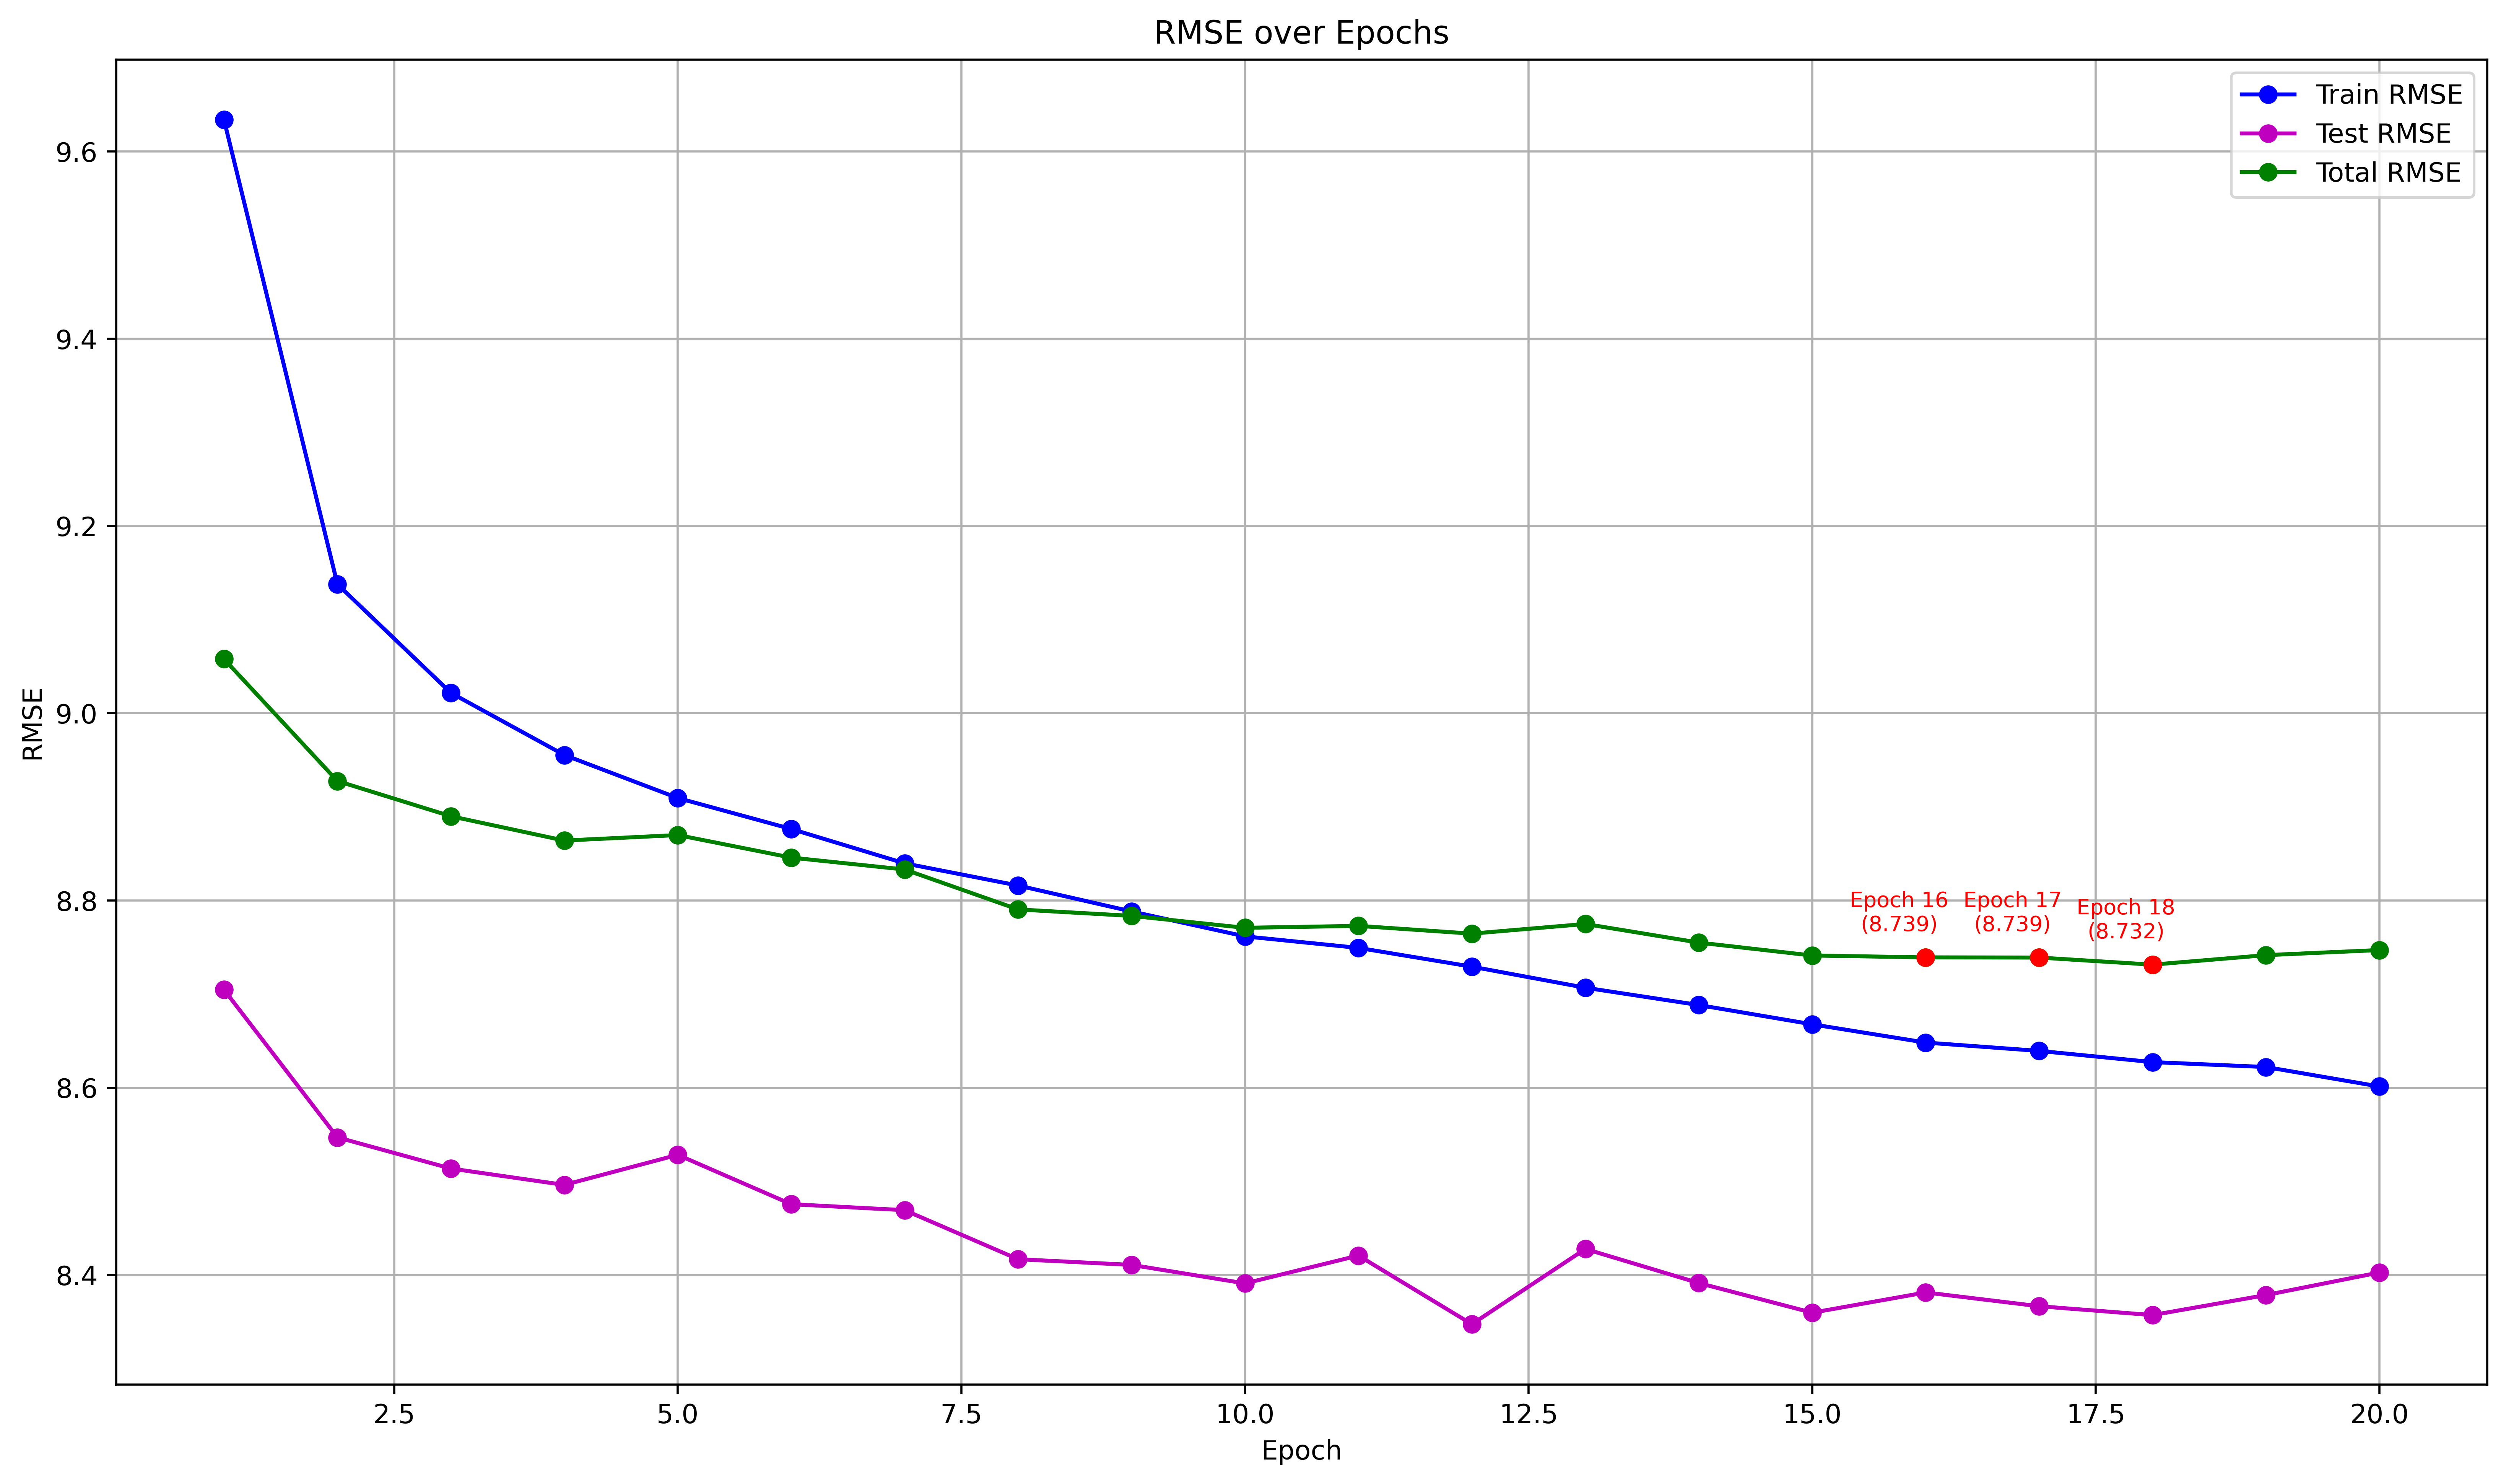

In [53]:
plt.figure(figsize=(16, 9), dpi=500)

# Plotting RMSE values
plt.plot(epochs, train_rmse_list, label='Train RMSE', marker='o', color='blue')
plt.plot(epochs, test_rmse_list, label='Test RMSE', marker='o', color='m')
plt.plot(epochs, total_rmse_list, label='Total RMSE', marker='o', color='green')

# Находим индексы трех минимальных значений RMSE_total
min_rmse_idx = np.argsort(total_rmse_list)[:3]

# Добавляем маркеры для минимальных точек
plt.scatter(np.array(epochs)[min_rmse_idx], np.array(total_rmse_list)[min_rmse_idx], color='red', zorder=5)

# Добавляем аннотации для минимальных точек
for idx in min_rmse_idx:
    plt.annotate(f'Epoch {idx + 1}\n({total_rmse_list[idx]:.3f})',
                 (epochs[idx], total_rmse_list[idx]),
                 textcoords="offset points",
                 xytext=(-10, 10),
                 ha='center',
                 fontsize=8,
                 color='red')

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over Epochs')
plt.legend()
plt.grid(True)

На графике изображено 3 минимальных значения RMSE_total, и они меньше 8.75, значит это чётко классно молодёжно

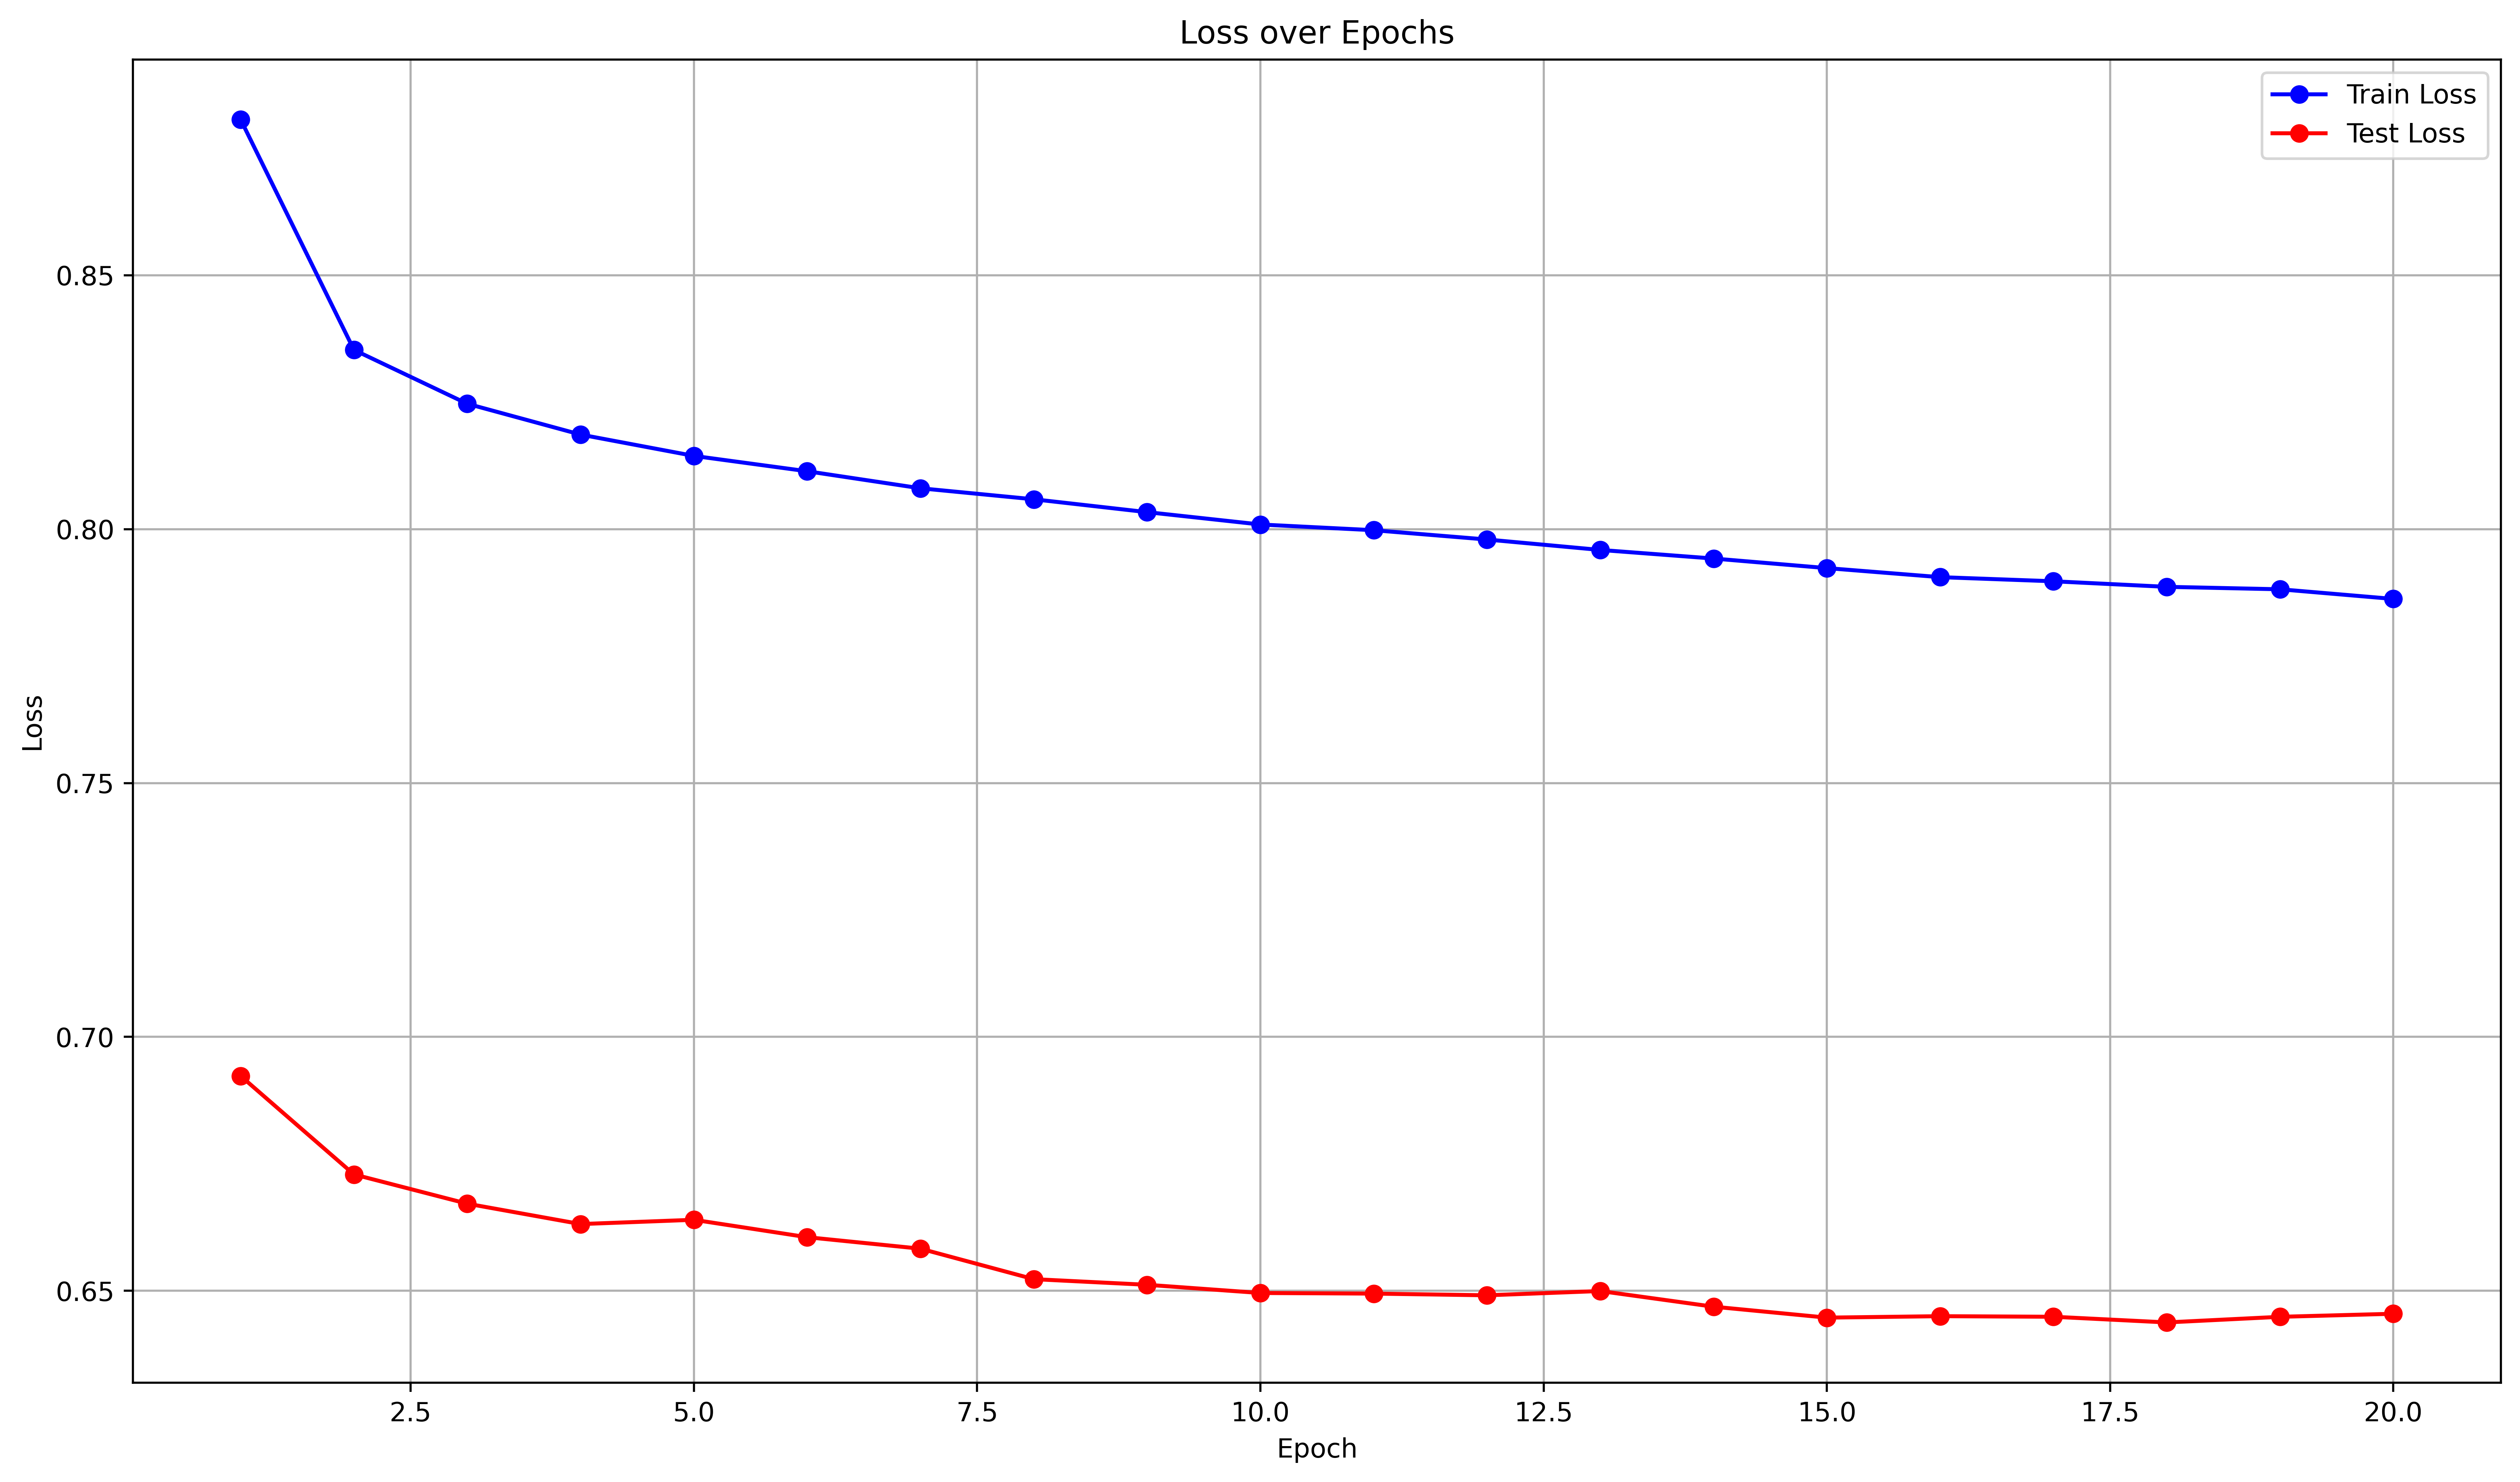

In [54]:
plt.figure(figsize=(16, 9), dpi=500)
plt.plot(epochs, train_loss_list, label='Train Loss', marker='o', color='blue')
plt.plot(epochs, test_loss_list, label='Test Loss', marker='o', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

На графике изображены кривые потерь для тренировочной и тестовой выборок в процессе обучения модели по эпохам

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.





## Отчёт

Я написал, что делал после каждой попытки, теперь поподробнее расскажу об архитектурах своего кода.

1. Базовая архитектура сети имеет 4 полно связных слоя и три слоя DropOut для регуляризации, ReLu я использовал для нелинейности между слоями, крайний слой не использует активацию, так как задача регрессии предполагает непрерывный выход.
2. Я использовал оптимизатор в основном SGD и один раз Adam. SGD: высокая скорость обучения, которая контролирует насколько сильно модель обновляется на каждом шаге; стохастичность - (может помочь модели выйти из локальных минимумов). Adam: включает в себя идеи двух алгоритмов оптимизации: RMSProp и Momentum, он сохраняет два момента, 1 - среднее значение, 2 - несмещённую оценку дисперсий градиентов.
3. **Learning rate** определяет размер шага, который мы делаем в направлении антиградиента функции потерь при обновлении весов. При слишком большом может нестабильно сходиться, при слишком маленьком - обучение будет идти очень медленно.
4. **Batch_size** определяет количество образцов данных, используемых для одного обновления весов. При большом batch size будет более стабильное вычисление весов, но потребуется больше вычислительных ресурсов, при маленьком может добавиться некоторая стохастичность к обучению, помогая выйти из локальных минимумов, но это может сделать обучение менее стабильным.
5. **Weight_decay** регуляризует веса, штрафуя большие значения весов, чтобы предотвратить переобучение. При высоком weight decay может произойти недоoбучение, при низком -- к переобучению.
6. То что я увеличил количество нейронов в каждом слое: улучшает способность нейросети аппроксимировать сложные функции и выявлять более сложные закономерности, но увелечение количества параметров может привести к переобучению. В моём случае вроде получилось сбалансировано.